# Writing Kanji with an MDN-RNN

- What kind of data can be predicted by a mixture density network RNN?
    - Sequential data that is _continuous_, not categorical.
- Drawing data is a good example, tend to want high resolution in 2 dimensions to draw.
    - not practical for categories
- Let's try modelling some _drawing_ data using an MDN-RNN.
- In this case we will use a dataset of Kanji

This example is similar to hardmaru's Kanji tutorial and the original Sketch-RNN repository:

- http://blog.otoro.net/2015/12/28/recurrent-net-dreams-up-fake-chinese-characters-in-vector-format-with-tensorflow/
- https://github.com/hardmaru/sketch-rnn

- The idea is to learn how to draw kanji characters from a dataset of vector representations. 
- This means learning how to move a pen in 2D space.
- The data consists of a sequence of pen movements (loations in 2D) and whether the pen is up or down.
- In this example, we will use one 3D MDN to model everything!

We will end up with a system that can invent "new" kanji---but it won't know how to stop drawing! E.g.:

![Kanji Test 1](figures/kanji_test_1.png)


In [1]:
import keras
from context import * # imports the MDN layer 
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

# Only for GPU use:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

Using TensorFlow backend.


### First download and process the dataset.

In [ ]:
# Train from David Ha's Kanji dataset from Sketch-RNN: https://github.com/hardmaru/sketch-rnn-datasets
# Other datasets in "Sketch 3" format should also work.
import urllib.request
url = 'https://github.com/hardmaru/sketch-rnn-datasets/raw/master/kanji/kanji.rdp25.npz'  
urllib.request.urlretrieve(url, './kanji.rdp25.npz')  

### Dataset:

Includes about 11000 handwritten kanji characters divied into training, validation, and testing sets.

For creative purposes, we may not need the validation or testing sets, and can just focus on the training set.

In [2]:
with np.load('./kanji.rdp25.npz') as data:
    train_set = data['train']
    valid_set = data['valid']
    test_set = data['test']
    
print("Training kanji:", len(train_set))
print("Validation kanji:", len(valid_set))
print("Testing kanji:", len(test_set))

Training kanji: 10358
Validation kanji: 600
Testing kanji: 500


### Looking at one example

Let's have a look at one example from the training data.

- Each example is a sequence of pen movements with three numbers:
    - The movement of the pen in the x-direction (left-right)
    - The movement of the pen in the y-direction (up-down)
    - Whether the pen is raised, or lowered touching the paper (1 = up, 0 = down).
    

In [3]:
# Have a look at the data.
example = train_set[99]
print("Shape:", example.shape)
print(example[:20])

Shape: (121, 3)
[[ 2.98828125e-01  5.28808594e-01  0.00000000e+00]
 [ 6.37207031e-01  2.72900391e+00  0.00000000e+00]
 [ 4.15000916e-02  2.96630859e+00  0.00000000e+00]
 [-3.72764587e-01  2.72597656e+01  0.00000000e+00]
 [-5.94665527e-01  1.10971680e+01  1.00000000e+00]
 [ 2.51953125e+00 -4.29375000e+01  0.00000000e+00]
 [ 9.25781250e+00 -1.05731201e+00  0.00000000e+00]
 [ 1.35036621e+01 -2.17260742e+00  0.00000000e+00]
 [ 3.00000000e+00 -2.99835205e-02  1.00000000e+00]
 [-1.47187500e+01  2.82031250e+00  0.00000000e+00]
 [ 9.49707031e-01  1.52001953e+00  0.00000000e+00]
 [-2.50007629e-01  3.85087891e+01  1.00000000e+00]
 [-1.28515625e+01 -2.49531250e+01  0.00000000e+00]
 [ 2.24399414e+01 -3.54003906e+00  0.00000000e+00]
 [ 3.00000000e+00 -2.00347900e-02  1.00000000e+00]
 [-2.58437500e+01  1.58906250e+01  0.00000000e+00]
 [ 2.37370605e+01 -2.64471436e+00  0.00000000e+00]
 [ 2.20068359e+00  6.46820068e-02  1.00000000e+00]
 [-2.62031250e+01  1.79375000e+01  0.00000000e+00]
 [ 2.34306641e+

### Reconstructing a training example

Lets try to plot this example:

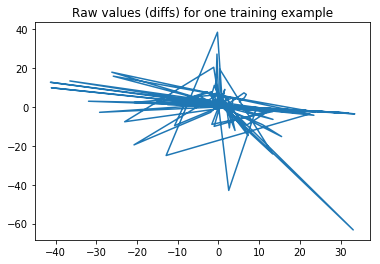

In [4]:
plt.plot(example.T[0], example.T[1])
plt.title("Raw values (diffs) for one training example")
plt.show()

- That didn't work very well as we were just plotting the raw values
    - (the difference between each pen movement)
- We can transform these into paper locations by using the `cumsum()` function.
- This will add each value to the sum of the previous in the array.

Here's a proper sketch:

In [ ]:
plt.plot(example.T[0].cumsum(), -1 * example.T[1].cumsum())
plt.title("Accumulated values for one training example")
plt.show()

(Note that this sketch ignores the pen's touching or not value.)

### Setup an MDN RNN

So let's set up an MDN RNN to learn how to create similar drawings.

Our RNN will have the following settings:

- 2 RNN layers.
- 256 LSTM units per RNN layer
- a 3-dimensional mixture layer with 10 mixtures.
- train for sequence length of 30.
- training for 100 epochs with a batch size of 64.

Here's a diagram:

![Diagram of the Kanji MDN-RNN](figures/kanji-mdn-diagram.png)



Why do we need a 3D mixture model?

- One dimension for `pen-X`, one for `pen-Y`, and one for `pen-UpDown`
- `pen-UpDown` isn't exactly a real number (it's either 0 or 1), but we can _make a simpler model_ by just adding another MDN dimension.
- When doing predictions, we can just round the `pen-UpDown` value up to 1 or down to 0. Easy!

In [5]:
# Training Hyperparameters:
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 100
SEED = 2345  # set random seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
OUTPUT_DIMENSION = 3
NUMBER_MIXTURES = 10

# Sequential model
model = keras.Sequential()

# Add two LSTM layers, make sure the input shape of the first one is (?, 30, 3)
model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None,SEQ_LEN,OUTPUT_DIMENSION), return_sequences=True))
model.add(keras.layers.LSTM(HIDDEN_UNITS))

# Here's the MDN layer, need to specify the output dimension (3) and number of mixtures (10)
model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))

# Now we compile the MDN RNN - need to use a special loss function with the right number of dimensions and mixtures.
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())

# Let's see what we have:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 256)           266240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
mdn_1 (MDN)                  (None, 70)                17990     
Total params: 809,542
Trainable params: 809,542
Non-trainable params: 0
_________________________________________________________________


## Process the Data and Train the Model

- Chop up the data into slices of the correct length, generate `X` and `y` for the training process.
- Very similar process to the previous RNN examples!
- We end up with 330000 examples - a pretty healthy dataset.

In [6]:
# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

# Prepare training data as X and Y.
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_singleton_format(slices)

X = np.array(X)
y = np.array(y)

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

Number of training examples:
X: (330546, 30, 3)
y: (330546, 3)


## Do the training!

- We're not going to train in the tutorial!
- These settings take about 220 seconds per epoch, about 6 hours for the whole training run.

In [ ]:
# Fit the model
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[keras.callbacks.TerminateOnNaN()])

Epoch 1/100
330546/330546 [==============================] - 541s 2ms/step - loss: 3.4301
Epoch 2/100
330546/330546 [==============================] - 545s 2ms/step - loss: 3.3140
Epoch 3/100
330546/330546 [==============================] - 540s 2ms/step - loss: 2.8272
Epoch 4/100
330546/330546 [==============================] - 544s 2ms/step - loss: 2.9048
Epoch 5/100
330546/330546 [==============================] - 543s 2ms/step - loss: 2.0915
Epoch 6/100
330546/330546 [==============================] - 543s 2ms/step - loss: 2.8084
Epoch 7/100
330546/330546 [==============================] - 541s 2ms/step - loss: 2.9481
Epoch 8/100
330546/330546 [==============================] - 543s 2ms/step - loss: 2.7268
Epoch 9/100
330546/330546 [==============================] - 538s 2ms/step - loss: 2.9255
Epoch 10/100
330546/330546 [==============================] - 541s 2ms/step - loss: 2.8454
Epoch 11/100
330546/330546 [==============================] - 543s 2ms/step - loss: 2.6868
Epoch 12

In [ ]:
model.save('kanji_mdnrnn_model.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.show()

## Try out the model! Generate some Kanji!

We need to create a decoding model with batch size 1 and sequence length 1.

In [ ]:
# Decoding Model
# Same as training model except for dimension and mixtures.

decoder = keras.Sequential()
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(1,1,OUTPUT_DIMENSION), return_sequences=True, stateful=True))
decoder.add(keras.layers.LSTM(HIDDEN_UNITS, stateful=True))
decoder.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))
decoder.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer=keras.optimizers.Adam())
decoder.summary()

decoder.load_weights('kanji_mdnrnn_model.h5') # load weights independently from file

## Generating drawings

- First need some helper functions to view the output.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def zero_start_position():
    """A zeroed out start position with pen down"""
    out = np.zeros((1, 1, 3), dtype=np.float32)
    out[0, 0, 2] = 1 # set pen down.
    return out

def generate_sketch(model, start_pos, num_points=100):
     return None

def cutoff_stroke(x):
    return np.greater(x,0.5) * 1.0

def plot_sketch(sketch_array):
    """Plot a sketch quickly to see what it looks like."""
    sketch_df = pd.DataFrame({'x':sketch_array.T[0],'y':sketch_array.T[1],'z':sketch_array.T[2]})
    sketch_df.x = sketch_df.x.cumsum()
    sketch_df.y = -1 * sketch_df.y.cumsum()
    # Do the plot
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    #ax1.scatter(sketch_df.x,sketch_df.y,marker='o', c='r', alpha=1.0)
    # Need to do something with sketch_df.z
    ax1.plot(sketch_df.x,sketch_df.y,'r-')
    plt.show()

## SVG Drawing Function

Here's Hardmaru's Drawing Functions from _write-rnn-tensorflow_. Big hat tip to Hardmaru for this!

Here's the source: https://github.com/hardmaru/write-rnn-tensorflow/blob/master/utils.py


In [ ]:
# Hardmaru's Drawing Functions from write-rnn-tensorflow
# Big hat tip
# Here's the source:
# https://github.com/hardmaru/write-rnn-tensorflow/blob/master/utils.py

import svgwrite
from IPython.display import SVG, display

def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

def draw_strokes(data, factor=1, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))

In [ ]:
# Predict a character and plot the result.
temperature = 0.1 # seems to work well with rather high temperature (2.5)

p = zero_start_position()
sketch = [p.reshape(3,)]

for i in range(400):
    params = decoder.predict(p.reshape(1,1,3))
    p = mdn.sample_from_output(params[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=temperature)
    sketch.append(p.reshape((3,)))

sketch = np.array(sketch)
decoder.reset_states()

sketch.T[2] = cutoff_stroke(sketch.T[2])
draw_strokes(sketch, factor=0.5)
#plot_sketch(sketch)